In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from copy import deepcopy as dc
import time

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

/home/rollylevente/miniconda3/envs/devenv/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


'cpu'

# Preprocessing

In [5]:
data = pd.read_csv("AMZN.csv")
data = data[["Date","Close"]]
data.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


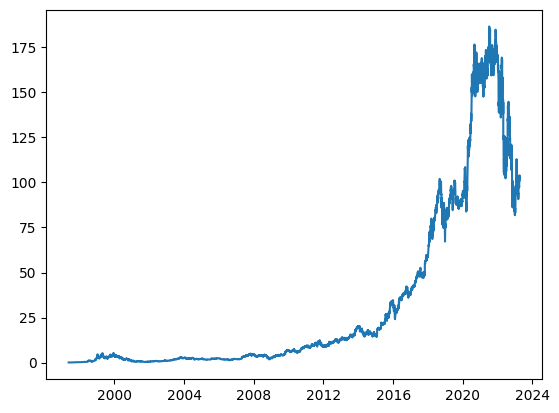

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'],data['Close'])

In [7]:
def prepare_df_for_lstm(df,n_steps):
    df = dc(df)

    df.set_index('Date', inplace = True)

    for i in range(1,n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace = True)

    return df

lookback = 7
shifted_df = prepare_df_for_lstm(data,lookback)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [8]:
shifted_df_as_np = shifted_df.to_numpy()

scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

# Torch setup

In [9]:
X = shifted_df_as_np[:,1:]
X = dc(np.flip(X, axis = 1))
y = shifted_df_as_np[:,0]

# manual train test split 
split_index = int(len(X) * 0.95)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

#X_train.shape,X_test.shape,y_train.shape,y_test.shape

X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6183, 7, 1), (326, 7, 1), (6183, 1), (326, 1))

In [10]:
# pytorch tensor setup
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self,i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)

In [12]:
batch_size = 16

train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle = False)

In [13]:
for _,batch in enumerate(train_loader):
    x_batch,y_batch = batch[0].to(device),batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


# LSTM model building

In [14]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out,_=self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out

def train_one_epoch():
    model.train(True)
    print(F'Epoch: {epoch+1}')
    running_loss = 0.0

    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: #print every 100 batches
            avg_loss_across_batches = running_loss/100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))

            running_loss = 0.0

    print()

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index,batch in enumerate(test_loader):
        x_batch,y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss:{0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [15]:
model = LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
learning_rate = 0.001
epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

start_time = time.time()
for epoch in range(epochs):
    train_one_epoch()
    validate_one_epoch()
print("---Total execution time: %s seconds ---" % (time.time() - start_time))

with torch.no_grad():
    predict = model(X_train.to(device)).to('cpu').numpy()

Epoch: 1
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss:0.003
***************************************************

Epoch: 2
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss:0.003
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss:0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss:0.004
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss:0.003
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss:0.002
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss:0.003
************************

In [18]:
# with torch.no_grad():
#     predict = model(X_train.to(device)).to('cpu').numpy()

# plt.plot(y_train, label = 'Actual Close')
# plt.plot(predict, label = 'Predicted Close')
# plt.xlabel('Day')
# plt.ylabel('Close')
# plt.legend()
# plt.show()

# Visualise train prediction against train actual closing values

In [19]:
# scale inverse
train_predictions = predict.flatten()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])
train_predictions

array([  0.61034889,   0.61011545,   0.60977085, ..., 171.27846531,
       170.37872747, 171.18319908])

In [20]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

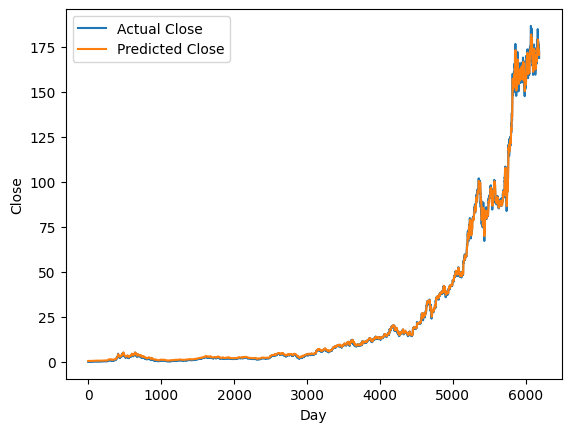

In [21]:
plt.plot(new_y_train, label = 'Actual Close')
plt.plot(train_predictions, label = 'Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Visualise test prediction against test actual closing values

In [22]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])

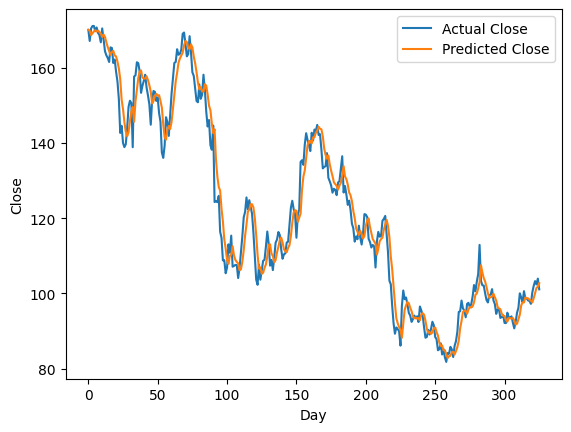

In [23]:
plt.plot(new_y_test, label = 'Actual Close')
plt.plot(test_predictions, label = 'Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()